In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43779")
client

<Client: 'tcp://127.0.0.1:43779' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:34629' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

xo = 50e3

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

In [6]:
ntheta = 36
ss = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                  % reg).scale/xo
ss

<xarray.DataArray 'scale' (scale: 47)>
array([9.24825986, 9.02129302, 8.79432618, 8.56735935, 8.34039251,
       8.11342567, 7.88645884, 7.659492  , 7.43252516, 7.20555832,
       6.97859149, 6.75162465, 6.52465781, 6.29769098, 6.07072414,
       5.8437573 , 5.61679047, 5.38982363, 5.16285679, 4.93588995,
       4.70892312, 4.48195628, 4.25498944, 4.02802261, 3.80105577,
       3.57408893, 3.3471221 , 3.12015526, 2.89318842, 2.66622158,
       2.43925475, 2.21228791, 1.98532107, 1.75835424, 1.5313874 ,
       1.30442056, 1.07745373, 0.87054724, 0.76886874, 0.68787468,
       0.6226582 , 0.5690005 , 0.52386193, 0.48441461, 0.45082619,
       0.42189398, 0.39655321])
Coordinates:
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04

In [7]:
iiter = 1419120
# iiter = 1421280
Zs = [18]

In [16]:
diags = np.concatenate((np.arange(-1,0),np.arange(1,2)))
# diags = np.arange(-1,2)

for ng in diags[:]:
    
    nx = ng
    ny = 0
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            dsUm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                   grid_dir=gdir,
                                   prefix=['diagUm'], delta_t=2e2,
                                   iters=iiter, 
                                   ignore_unknown_vars=True
                                  ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
                                                                       'Zu','Zp1']
                                                                     ).sel(
                                                                   YC=slice(ys[reg]-5+ny/12,
                                                                            ys[reg]+5+ny/12),
                                                                   XG=slice(xs[reg]-5+nx/12,
                                                                            xs[reg]+5+nx/12)
                                                                      ).isel(time=0)
            dsVm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                   grid_dir=gdir,
                                   prefix=['diagVm'], delta_t=2e2,
                                   iters=iiter, 
                                   ignore_unknown_vars=True
                                  ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
                                                                       'Zu','Zp1']
                                                                     ).sel(
                                                                   YG=slice(ys[reg]-5+ny/12,
                                                                            ys[reg]+5+ny/12),
                                                                   XC=slice(xs[reg]-5+nx/12,
                                                                            xs[reg]+5+nx/12)
                                                                      ).isel(time=0)
            ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['diagUm'], delta_t=2e2,
                                     iters=iiter, 
                                     ignore_unknown_vars=True
                                    ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
                                                                         'Zu','Zp1']
                                                                       ).chunk({'YC':ychunk,
                                                                                'XG':xchunk,
                                                                                'Z':10}
                                                                              ).isel(time=0)
            Um_dEdx = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                                          % (nmemb)), itrs=iiter, 
                                                  rec=3,    # U from surface pressure
                                 # usememmap=True
                                                 ),
                                   dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                                  ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                        XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                       )
            Um_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                                          % (nmemb)), itrs=iiter, 
                                                  rec=5,    # Vertical dissipation
                                 # usememmap=True
                                                 ),
                                   dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                                  ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                        XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                       )
            ds_raw.close()
            ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['diagVm'], delta_t=2e2,
                                     iters=iiter, 
                                     ignore_unknown_vars=True
                                    ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
                                                                         'Zu','Zp1']
                                                                       ).chunk({'YG':ychunk,
                                                                                'XC':xchunk,
                                                                                'Z':10}
                                                                              ).isel(time=0)
            Vm_dEdy = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                                          % (nmemb)), itrs=iiter, 
                                                  rec=3,    # U from surface pressure
                                 # usememmap=True
                                                 ),
                                   dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                                  ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                        XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                       )
            Vm_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                                          % (nmemb)), itrs=iiter, 
                                                  rec=5,    # Vertical dissipation
                                 # usememmap=True
                                                 ),
                                   dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                                  ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                        XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                       )
            ds_raw.close()
        else:
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            ds = xr.concat([ds, ds1], dim='nmemb')
            ds1.close()
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagUm'], delta_t=2e2,
                                  iters=iiter, 
                                  ignore_unknown_vars=True
                                 ).reset_coords(drop=True).drop_dims(['Zl','Zu','Zp1']
                                                                    ).sel(
                                                                  YC=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  YG=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  XC=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12),
                                                                  XG=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12)
                                                                         ).isel(time=0)
        
            dsUm = xr.concat([dsUm, ds1], dim='nmemb')
            ds1.close()
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagVm'], delta_t=2e2,
                                  iters=iiter, 
                                  ignore_unknown_vars=True
                                 ).reset_coords(drop=True).drop_dims(['Zl','Zu','Zp1']
                                                                    ).sel(
                                                                  YC=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  YG=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  XC=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12),
                                                                  XG=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12)
                                                                         ).isel(time=0)

            dsVm = xr.concat([dsVm, ds1], dim='nmemb')
            ds1.close()
            
            ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['diagUm'], delta_t=2e2,
                                     iters=iiter, 
                                     ignore_unknown_vars=True
                                    ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
                                                                         'Zu','Zp1']
                                                                       ).chunk({'YC':ychunk,
                                                                                'XG':xchunk,
                                                                                'Z':10}
                                                                              ).isel(time=0)
            Um_dEdx = xr.concat([Um_dEdx, 
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                                'memb%03d/run1967/ocn/diagUm' 
                                                                 % (nmemb)), itrs=iiter, 
                                                         rec=3,    # U from surface pressure
                                                  # usememmap=True
                                                            ),
                                              dims=ds_raw.TOTUTEND.dims, 
                                              coords=ds_raw.TOTUTEND.coords
                                             ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
                                ], dim='nmemb')
            Um_Disv = xr.concat([Um_Disv, 
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                                'memb%03d/run1967/ocn/diagUm' 
                                                                 % (nmemb)), itrs=iiter, 
                                                             rec=5,    # Vertical dissipation
                                                  # usememmap=True
                                                            ),
                                              dims=ds_raw.TOTUTEND.dims, 
                                              coords=ds_raw.TOTUTEND.coords
                                             ).sel(YC=slice(ys[reg]-5+ny/12,
                                                            ys[reg]+5+ny/12),
                                                   XG=slice(xs[reg]-5+nx/12,
                                                            xs[reg]+5+nx/12)
                                                  )
                                ], dim='nmemb')
            ds_raw.close()
            ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['diagVm'], delta_t=2e2,
                                     iters=iiter, 
                                     ignore_unknown_vars=True
                                    ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
                                                                         'Zu','Zp1']
                                                                       ).chunk({'YG':ychunk,
                                                                                'XC':xchunk,
                                                                                'Z':10}
                                                                              ).isel(time=0)
            Vm_dEdy = xr.concat([Vm_dEdy, 
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                                'memb%03d/run1967/ocn/diagVm' 
                                                                 % (nmemb)), itrs=iiter, 
                                                         rec=3,    # U from surface pressure
                                                  # usememmap=True
                                                            ),
                                              dims=ds_raw.TOTVTEND.dims, 
                                              coords=ds_raw.TOTVTEND.coords
                                             ).sel(YG=slice(ys[reg]-5+ny/12,
                                                            ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,
                                                            xs[reg]+5+nx/12))
                                ], dim='nmemb')
            Vm_Disv = xr.concat([Vm_Disv, 
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                                'memb%03d/run1967/ocn/diagVm' 
                                                                     % (nmemb)), itrs=iiter, 
                                                             rec=5,    # Vertical dissipation
                                                  # usememmap=True
                                                            ),
                                              dims=ds_raw.TOTVTEND.dims, 
                                              coords=ds_raw.TOTVTEND.coords
                                             ).sel(YG=slice(ys[reg]-5+ny/12,
                                                            ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,
                                                            xs[reg]+5+nx/12))
                                ], dim='nmemb')
            ds_raw.close()
        # print(nmemb)

                # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(None,-1))
        
    grid = Grid(ds, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #                           'Y': {'center': 'YC', 'left': 'YG'},
            #                           'X': {'center': 'XC', 'left': 'XG'}}
           )
    
    dsUm.coords['nmemb'] = ('nmemb',nmembs)
    if len(dsUm.XG) > len(ds.XC):
        dsUm = dsUm.isel(XG=slice(None,-1))
    elif len(dsUm.XG) < len(ds.XC):
        dsUm = dsUm.isel(XC=slice(None,-1))
    dsVm.coords['nmemb'] = ('nmemb',nmembs)
    Um_dEdx.coords['nmemb'] = ('nmemb',nmembs)
    Um_Disv.coords['nmemb'] = ('nmemb',nmembs)
    if len(Um_dEdx.XG) > len(ds.XC):
        Um_dEdx = Um_dEdx.isel(XG=slice(None,-1))
    # elif len(Um_dEdx.XG) < len(dsb.XC):
    #     Um_dEdx = Um_dEdx.isel(XC=slice(None,-1))
    if len(Um_Disv.XG) > len(ds.XC):
        Um_Disv = Um_Disv.isel(XG=slice(None,-1))
    # elif len(Um_Disv.XG) < len(dsb.XC):
    #     Um_Disv = Um_Disv.isel(XC=slice(None,-1))
    Vm_dEdy.coords['nmemb'] = ('nmemb',nmembs)
    Vm_Disv.coords['nmemb'] = ('nmemb',nmembs)
    
            
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    )
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    )
    Ny, Nx = xT.shape
    xT = xT - xT.isel(XC=Nx//2)
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = ds.THETA.isel(nmemb=0,Z=0).shape

    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    # ss = xr.DataArray(np.linspace(2*10,10*xo,30)/xo, dims=['scale'], 
    #                    coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
    #                   )
    
    up = ds.UVEL
    upC = grid.interp(up,'X',boundary='extend'
                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
    vp = ds.VVEL
    vpC = grid.interp(vp,'Y',boundary='extend'
                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
    wp = ds.WVEL
    
    rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                      (xxx, yyy) 
                     ).T
    
    uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )

    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            uterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
                                                    (upC*ds.rA).isel(nmemb=nn,Z=iz
                                                                    ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            vterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (vpC*ds.rA).isel(nmemb=nn,Z=iz
                                                                    ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 

    uterp = uterp / rAterp
    vterp = vterp / rAterp
    
    Tp = grid.interp((dsUm.TOTUTEND),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ap = grid.interp((dsUm.Um_Advec),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Pp = grid.interp((dsUm.Um_dPHdx),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    # Dp = dsUm.Um_Diss - dsUmb.Um_Diss
    ABp = grid.interp((dsUm.AB_gU),
                      'X',boundary='extend'
                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
    
    Pterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Tterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    ABterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                          coords={'nmemb':nmembs,'Z':upC.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )


    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            Tterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Tp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            Pterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Pp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T
            Aterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Ap*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            ABterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                     (ABp*ds.rA).isel(nmemb=nn,Z=iz
                                                                     ).values.flatten(),
                                                     (xxx, yyy) 
                                                    ).T 

    Tterp = Tterp / rAterp
    Aterp = Aterp / rAterp
    Pterp = Pterp / rAterp
    ABterp = ABterp / rAterp


    iso_uAB = xwavelet.wvlt_cross_spectrum(
                        uterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_uP = xwavelet.wvlt_cross_spectrum(
                        uterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_uT = xwavelet.wvlt_cross_spectrum(
                        uterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_uA = xwavelet.wvlt_cross_spectrum(
                        uterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    dsave = iso_uAB.to_dataset(name='iso_uAB')
    dsave['iso_uP'] = iso_uP
    dsave['iso_uT'] = iso_uT
    dsave['iso_uA'] = iso_uA
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-u_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-u_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-u_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-u_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    
    Tp = grid.interp((dsVm.TOTVTEND),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ap = grid.interp((dsVm.Vm_Advec),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Pp = grid.interp((dsVm.Vm_dPHdy),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    # Dp = dsUm.Um_Diss - dsUmb.Um_Diss
    ABp = grid.interp((dsVm.AB_gV),
                      'Y',boundary='extend'
                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
    
    Pterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Tterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    ABterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                          coords={'nmemb':nmembs,'Z':vpC.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )


    for iz in range(len(vpC.Z)):
        for nn in range(len(nmembs)):
            Tterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Tp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            Pterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Pp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            Aterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Ap*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            ABterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                     (ABp*ds.rA).isel(nmemb=nn,Z=iz
                                                                     ).values.flatten(),
                                                     (xxx, yyy) 
                                                    ).T 

    Tterp = Tterp / rAterp
    Aterp = Aterp / rAterp
    Pterp = Pterp / rAterp
    ABterp = ABterp / rAterp


    iso_vAB = xwavelet.wvlt_cross_spectrum(
                        vterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_vP = xwavelet.wvlt_cross_spectrum(
                        vterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_vT = xwavelet.wvlt_cross_spectrum(
                        vterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_vA = xwavelet.wvlt_cross_spectrum(
                        vterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    dsave = iso_vAB.to_dataset(name='iso_vAB')
    dsave['iso_vP'] = iso_vP
    dsave['iso_vT'] = iso_vT
    dsave['iso_vA'] = iso_vA
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-v_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-v_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-v_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-v_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    
    
    Dp = grid.interp((dsUm.Um_Diss)
                     + (Um_Disv),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ep = grid.interp((Um_dEdx),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Dterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Eterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )


    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            Dterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Dp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            Eterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
                                                    (Ep*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 

    Dterp = Dterp / rAterp
    Eterp = Eterp / rAterp

    iso_uD = xwavelet.wvlt_cross_spectrum(
                        uterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )
    iso_uE = xwavelet.wvlt_cross_spectrum(
                        uterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )

    dsave = iso_uD.to_dataset(name='iso_uD')
    dsave['iso_uE'] = iso_uE
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    
    Dp = grid.interp((dsVm.Vm_Diss)
                     + (Vm_Disv),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ep = grid.interp((Vm_dEdy),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Dterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Eterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )

    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            Dterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
                                                    (Dp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            Eterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                    (Ep*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 

    Dterp = Dterp / rAterp
    Eterp = Eterp / rAterp

    iso_vD = xwavelet.wvlt_cross_spectrum(
                        vterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )
    iso_vE = xwavelet.wvlt_cross_spectrum(
                        vterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )

    dsave = iso_vD.to_dataset(name='iso_vD')
    dsave['iso_vE'] = iso_vE
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    
    # client.restart()
    print(ng)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags_Tot-u_00-01.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags_Tot-v_00-01.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-ext_Tot-u_00-01.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-ext_Tot-v_00-01.zarr
-1


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags_Tot-u_0001.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags_Tot-v_0001.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-ext_Tot-u_0001.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/A/0001419120/isoDiags-ext_Tot-v_0001.zarr
1


In [39]:
iZ = 1
iiter = 1419120
ds0 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-u.zarr' 
                              % (sreg[reg],iiter))
                     ).isel(Z=iZ)
ds1 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags_Tot-v.zarr' 
                              % (sreg[reg],iiter))
                     ).isel(Z=iZ)
ds2 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u.zarr' 
                              % (sreg[reg],iiter))
                     ).isel(Z=iZ)
ds3 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v.zarr' 
                              % (sreg[reg],iiter))
                     ).isel(Z=iZ)

ds0

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 48, scale: 47)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    iso_uA   (nmemb, angle, scale) float64 ...
    iso_uAB  (nmemb, angle, scale) float64 ...
    iso_uP   (nmemb, angle, scale) float64 ...
    iso_uT   (nmemb, angle, scale) float64 ...

In [40]:
ns = 1
    
for ny in range(-ns,ns+1):
    for nx in range(-ns,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-u_-%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-v_-%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-u_%02d-%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-v_%02d-%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-u_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_Tot-v_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds1

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 432, scale: 47)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    iso_vA   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    iso_vAB  (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    iso_vP   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    iso_vT   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>

In [41]:
ns = 1
    
for ny in range(-ns,ns+1):
    for nx in range(-ns,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_-%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_-%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                #     try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_%02d-%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_%02d-%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-u_%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                    'Z0452/Points/%s/%010d/isoDiags-ext_Tot-v_%02d%02d.zarr' 
                                                                % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds3

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 432, scale: 47)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04
Data variables:
    iso_vD   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>
    iso_vE   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 47), meta=np.ndarray>

In [37]:
ubx = (grid.diff(ub*ds.dyG*ds.drF,'X',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
uby = (grid.interp(grid.interp(grid.diff(ub*ds.dxC*ds.drF,'Y',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
ubz = (-grid.interp(grid.interp(grid.diff(ub,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'X',boundary='extend')).isel(Z=[14,18,24]).load()
vby = (grid.diff(vb*ds.dyC*ds.drF,'Y',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
vbx = (grid.interp(grid.interp(grid.diff(vb*ds.dxG*ds.drF,'X',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
vbz = (-grid.interp(grid.interp(grid.diff(vb,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'Y',boundary='extend')).isel(Z=[14,18,24]).load()
# print(ubx,uby,vby,vbx)

upup = grid.interp(up**2,'X',boundary='extend').isel(Z=[14,18,24]).load()
vpup = (grid.interp(vp,'Y',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
wpup = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
vpvp = grid.interp(vp**2,'Y',boundary='extend').isel(Z=[14,18,24]).load()
wpvp = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(vp,'Y',boundary='extend')).isel(Z=[14,18,24]).load()

In [38]:
uputerp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        uputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uterbx = uterbx / rAterp
vterbx = vterbx / rAterp    
uterby = uterby / rAterp
vterby = vterby / rAterp    
uterbz = uterbz / rAterp
vterbz = vterbz / rAterp    
uputerp = uputerp / rAterp
vputerp = vputerp / rAterp
wputerp = wputerp / rAterp
vpvterp = vpvterp / rAterp
wpvterp = wpvterp / rAterp
            
ntheta = 36

iso_upupUx = xwavelet.wvlt_cross_spectrum(
                    uputerp, uterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpupUy = xwavelet.wvlt_cross_spectrum(
                    vputerp, uterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpupUz = xwavelet.wvlt_cross_spectrum(
                    wputerp, uterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_upvpVx = xwavelet.wvlt_cross_spectrum(
                    vputerp, vterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpvpVy = xwavelet.wvlt_cross_spectrum(
                    vpvterp, vterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpvpVz = xwavelet.wvlt_cross_spectrum(
                    wpvterp, vterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

        
dsave = iso_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = iso_vpupUy
dsave['wpupUz'] = iso_wpupUz
dsave['upvpVx'] = iso_upvpVx
dsave['vpvpVy'] = iso_vpvpVy
dsave['wpvpVz'] = iso_wpvpVz
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [39]:
upuinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        upuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uinterbx = uinterbx / rAterp
vinterbx = vinterbx / rAterp    
uinterby = uinterby / rAterp
vinterby = vinterby / rAterp    
uinterbz = uinterbz / rAterp
vinterbz = vinterbz / rAterp    
upuinterp = upuinterp / rAterp
vpuinterp = vpuinterp / rAterp
wpuinterp = wpuinterp / rAterp
vpvinterp = vpvinterp / rAterp
wpvinterp = wpvinterp / rAterp
            

for i in range(len(nmembs)):
    if i == 0:
        cs_upupUx = xrft.cross_spectrum(
                            upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpupUy = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpupUz = xrft.cross_spectrum(
                            wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_upvpVx = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpvpVy = xrft.cross_spectrum(
                            vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpvpVz = xrft.cross_spectrum(
                            wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
    else:
        cs_upupUx = xr.concat([cs_upupUx,
                               xrft.cross_spectrum(
                                        upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpupUy = xr.concat([cs_vpupUy,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpupUz = xr.concat([cs_wpupUz,
                               xrft.cross_spectrum(
                                        wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_upvpVx = xr.concat([cs_upvpVx,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpvpVy = xr.concat([cs_vpvpVy,
                               xrft.cross_spectrum(
                                        vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpvpVz = xr.concat([cs_wpvpVz,
                               xrft.cross_spectrum(
                                        wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')

dsave = cs_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = cs_vpupUy
dsave['wpupUz'] = cs_wpupUz
dsave['upvpVx'] = cs_upvpVx
dsave['vpvpVy'] = cs_vpvpVy
dsave['wpvpVz'] = cs_wpvpVz
dsave.coords['nmemb'] = nmembs
dsave.encoding = {}
fname = op.join(savedir,'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg)
print(fname)
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/topog/tuchida/Wavelet-spectrum/crossFourierDiags-MtE_reenvisioned_region00_1967-01-01.zarr


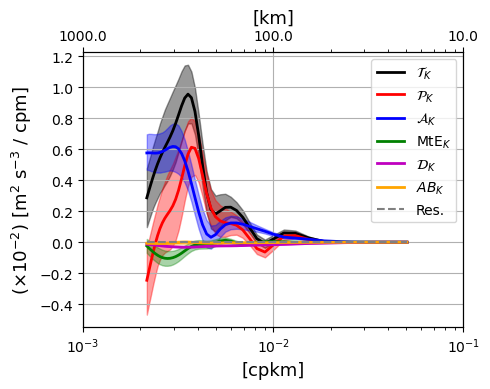

In [43]:
for reg in range(0,len(xs)-5):
    # ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    
    datas = ((ds0.iso_uT + ds1.iso_vT).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Tres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds0.iso_uAB + ds1.iso_vAB).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    ABres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng
                     )
    datas = ((ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
             ).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Pres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds2.iso_uD + ds3.iso_vD).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Dres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
        
    
    Tk = (ds0.iso_uT + ds1.iso_vT).mean(['nmemb']).sum('angle').compute()
    ABk = (ds0.iso_uAB + ds1.iso_vAB).mean(['nmemb']).sum('angle').compute()
    
    Pk = (ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
         ).mean(['nmemb']).sum('angle').compute()
    Dk = (ds2.iso_uD + ds3.iso_vD).mean(['nmemb']).sum('angle').compute()
    
    datas = ((ds0.iso_uA + ds1.iso_vA).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Ares = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    
    Ak = (ds0.iso_uA + ds1.iso_vA).mean(['nmemb']).sum('angle').compute()
    
    res = Tk/86400 - (Pk + (ds0.iso_uA + ds1.iso_vA
                           ).mean(['nmemb']).sum('angle').compute() 
                      + Dk + ABk
                     )
            
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Tres.confidence_interval.low/86400., 
                    Tres.confidence_interval.high/86400., 
                    alpha=.4, color='k')
    ax.fill_between((ds0.scale)**-1*1e3, Pres.confidence_interval.low, 
                    Pres.confidence_interval.high, 
                    alpha=.38, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Ares.confidence_interval.low, 
                    Ares.confidence_interval.high, 
                    alpha=.36, color='b')
    ax.fill_between((ds0.scale)**-1*1e3, Dres.confidence_interval.low, 
                    Dres.confidence_interval.high, 
                    alpha=.32, color='m')
    ax.fill_between((ds0.scale)**-1*1e3, ABres.confidence_interval.low, 
                    ABres.confidence_interval.high, 
                    alpha=.3, color='orange')
    
    ax.plot((ds0.scale)**-1*1e3, Tk*np.diff(ds0.angle)[0]*2*1e2/86400.,
            'k', lw=2, label=r"$\mathcal{T}_K$")
    ax.plot((ds0.scale)**-1*1e3, Pk*np.diff(ds0.angle)[0]*2*1e2,
            'r', lw=2, label=r"$\mathcal{P}_K$")
    ax.plot((ds0.scale)**-1*1e3, Ak*np.diff(ds0.angle)[0]*2*1e2,
            'b', lw=2, label=r"$\mathcal{A}_K$")
    ax.plot((ds0.scale)**-1*1e3, (Dk)*np.diff(ds0.angle)[0]*2*1e2,
            'm', lw=2, label=r"$\mathcal{D}_K$")
    ax.plot((ds0.scale)**-1*1e3, ABk*np.diff(ds0.angle)[0]*2*1e2,
            c='orange', lw=2, label=r"$AB_K$")
    ax.plot((ds0.scale)**-1*1e3, res*np.diff(ds0.angle)[0]*2*1e2, 
            c='grey', ls='--', label=r"Res.")

    ax.set_xscale('log')
    ax2.set_xscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-2}$) [m$^2$ s$^{-3}$ / cpm]", fontsize=13)
    ax.grid(True)
    if reg % 5 == 0:
        ax.legend(loc='upper right', fontsize=10)
    plt.savefig(op.join(savedir,'Figs/SpecTKEbudget_3x3_Region%02d_Z452.pdf' % reg))
    plt.show()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


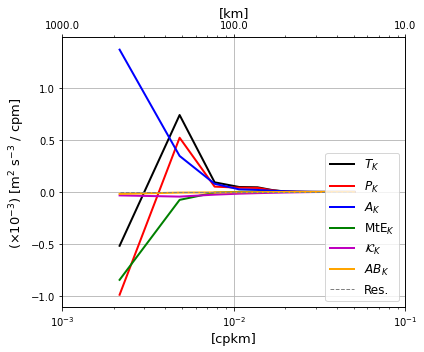

In [28]:
for reg in range(len(xs)-5):
    ds0 = xr.open_dataset(op.join(savedir,'crossFourierDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1 = xr.open_dataset(op.join(savedir,'crossFourierDiags_v_region%02d_1967-01-01.zarr' % reg))
    ds2 = xr.open_dataset(op.join(savedir,'crossFourierDiags-ext_u_region%02d_1967-01-01.zarr' % reg))
    ds3 = xr.open_dataset(op.join(savedir,'crossFourierDiags-ext_v_region%02d_1967-01-01.zarr' % reg))
    
    Tk = xrft.isotropize((ds0.cs_uT + ds1.cs_vT).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    ABk = xrft.isotropize((ds0.cs_uAB + ds1.cs_vAB).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    Pk = xrft.isotropize((ds0.cs_uP + ds1.cs_vP + ds2.cs_uE + ds3.cs_vE).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    Dk = xrft.isotropize((ds2.cs_uD + ds3.cs_vD).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    ds4 = xr.open_dataset(op.join(savedir,'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    Ak = xrft.isotropize((ds0.cs_uA + ds1.cs_vA
                          - (ds4.MtEu + ds4.MtEv)
                         ).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    MtEk = xrft.isotropize((ds4.MtEu + ds4.MtEv).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    res = Tk/86400 - (Pk + xrft.isotropize((ds0.cs_uA + ds1.cs_vA).mean(['nmemb']).real, 
                                           ["freq_YC","freq_XC"], truncate=True).compute() 
                      + Dk + ABk)
            
            
    fig, ax = plt.subplots(figsize=(6,5))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    ax.plot(Tk.freq_r*1e3, Tk.isel(Z=1)*1e3/86400.,
            'k', lw=2, label=r"$T_K$")
    ax.plot(Tk.freq_r*1e3, Pk.isel(Z=1)*1e3,
            'r', lw=2, label=r"$P_K$")
    ax.plot(Tk.freq_r*1e3, Ak.isel(Z=1)*1e3,
            'b', lw=2, label=r"$A_K$")
    ax.plot(Tk.freq_r*1e3, MtEk.isel(Z=1)*1e3,
            'g', lw=2, label=r"MtE$_K$")
    ax.plot(Tk.freq_r*1e3, (Dk).isel(Z=1)*1e3,
            'm', lw=2, label=r"$\mathcal{K}_K$")
    ax.plot(Tk.freq_r*1e3, ABk.isel(Z=1)*1e3,
            c='orange', lw=2, label=r"$AB_K$")
    ax.plot(Tk.freq_r*1e3, res.isel(Z=1)*1e3, 
            c='grey', ls='--', lw=1, label=r"Res.")

    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax2.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-3}$) [m$^2$ s$^{-3}$ / cpm]", fontsize=13)
    ax.grid(True)
    if reg == 0:
        ax.legend(loc='lower right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/FourierSpecKEbudget_Region%02d_Z452.pdf' % reg))
    plt.show()

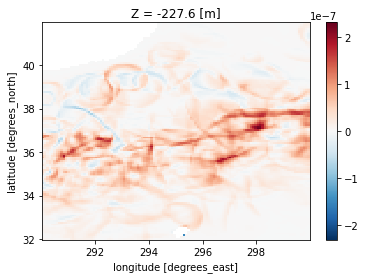

In [44]:
(grid.interp(upDv,'X',boundary='extend') 
 + grid.interp(vpDv,'Y',boundary='extend')
).isel(Z=14).plot()